## 图像风格转换实验
参考链接: [PyTorch 实现图像风格迁移”实验报告](https://www.lanqiao.cn/courses/reports/1523826/)

### 利用 OpenCV 来对这两张图片进行展示：

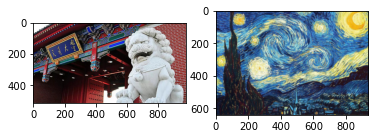

In [5]:
import cv2
import matplotlib.pyplot as plt
content_path = "/home/sjt_758/workspace/style_trans/content/sjtu.jpg"
style_path = "/home/sjt_758/workspace/style_trans/style/starry.jpg"
plt.subplot(121)
figure = cv2.imread(content_path)
plt.imshow(cv2.cvtColor(figure,cv2.COLOR_BGR2RGB))
# plt.imshow(figure)
plt.subplot(122)
figure = cv2.imread(style_path)
plt.imshow(cv2.cvtColor(figure,cv2.COLOR_BGR2RGB))
# plt.imshow(figure)

### 由于这两张图片的原始大小不同，且为了保证后面放入任何图片都可以对其进行迁移。我们需要对图片进行预处理操作：

In [14]:
import PIL.Image as Image
import torchvision.transforms as transforms
img_size = 512

def load_img(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img = transforms.ToTensor()(img)
    
    img = img.unsqueeze(0)
    return img

### 加载这两张图片，并将其处理成神经网络能够使用的类型：

In [17]:
import torch 
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
style_img = load_img(style_path)
style_img = Variable(style_img).to(device)
content_img = load_img(content_path)
content_img = Variable(content_img).to(device)
print(style_img.size(), content_img.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


### 定义内容损失函数

In [20]:
import torch.nn as nn 

class Content_Loss(nn.Module):
    def __init__(self,target,weight):
        super(Content_Loss,self).__init__()
        self.weight = weight
        self.target = target.detach()*self.weight
        self.criterion = nn.MSELoss()
    
    def forward(self,input):
        self.loss = self.criterion(input*self.weight,self.target)
        out = input.clone()
        return out
    def backward(self,retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

### 构造一个以 content_img 为目标的损失函数

In [21]:
cl = Content_Loss(content_img, 1)
# 随机图片
rand_img = torch.randn(content_img.data.size(), device=device)
cl.forward(rand_img)
print(cl.loss)

tensor(1.2728, device='cuda:0')


### 风格损失函数

In [22]:
class Gram(nn.Module):
    def __init__(self):
        super(Gram, self).__init__()

    def forward(self, input):
        a, b, c, d = input.size()
        # 将特征图变换为 2 维向量
        feature = input.view(a * b, c * d)
        # 内积的计算方法其实就是特征图乘以它的逆
        gram = torch.mm(feature, feature.t())
        # 对得到的结果取平均值
        gram /= (a * b * c * d)
        return gram


gram = Gram()
gram

Gram()

### 现在让我们来提取我们的风格图片 S 的风格：

In [23]:
target = gram(style_img)
# 此时 style_img 的通道为3 所以产生的风格特征为 3×3
target

tensor([[0.0622, 0.0710, 0.0636],
        [0.0710, 0.0870, 0.0852],
        [0.0636, 0.0852, 0.0946]], device='cuda:0')

### 采用交叉熵损失来计算任意两张图层的风格损失

In [24]:
class Style_Loss(nn.Module):
    def __init__(self, target, weight):
        super(Style_Loss, self).__init__()
        # weight 和内容函数相似，表示的是权重 beta
        self.weight = weight
        # targer 表示图层目标。即新图像想要拥有的风格
        # 即保存目标风格
        self.target = target.detach() * self.weight
        self.gram = Gram()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 加权计算 input 的 Gram 矩阵
        G = self.gram(input) * self.weight
        # 计算真实的风格和想要得到的风格之间的风格损失
        self.loss = self.criterion(G, self.target)
        out = input.clone()
        return out
    # 向后传播

    def backward(self, retain_variabels=True):
        self.loss.backward(retain_graph=retain_variabels)
        return self.loss

### 传入风格目标 target，得到一个可以计算任何图像与 target 之间的风格差异的损失函数

In [25]:
sl = Style_Loss(target, 1000)
# 传入一张随机图片进行测试
rand_img = torch.randn(style_img.data.size(), device=device)
# 损失函数层向前传播，进而得到损失
sl.forward(rand_img)
sl.loss

tensor(24942.9375, device='cuda:0')

### 下载预训练模型

In [26]:
import torchvision.models as models
# 设置与预训练模型所在连接
torch.utils.model_zoo.load_url("https://labfile.oss.aliyuncs.com/courses/861/vgg19_pre.zip")

/home/sjt_758/anaconda3/envs/torch/lib/python3.9/site-packages/torch/hub.py:518: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


OrderedDict([('features.0.weight',
              tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
                        [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
                        [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],
              
                       [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
                        [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
                        [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],
              
                       [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
                        [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
                        [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],
              
              
                      [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
                        [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
                        [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],
              
                       [[ 2.8746e-01, -3.3338e-01, -4.5564e-01],
                        [ 3.7836e-01, -2

### 加载 VGG19 的网络结构和所对应的权重

In [27]:
vgg = models.vgg19(pretrained=True).features
vgg = vgg.to(device)
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### 构造上面的网络结构

In [28]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# 初始化一个 空的神经网络 model
model = nn.Sequential()
model = model.to(device)
# 构造网络模型，并且返回这些损失函数


def get_style_model_and_loss(style_img, content_img, cnn=vgg, style_weight=1000, content_weight=1,
                             content_layers=content_layers_default,
                             style_layers=style_layers_default):
    content_loss_list = []
    style_loss_list = []
    gram = Gram()
    gram = gram.to(device)

    i = 1
    for layer in cnn:
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)
            if name in content_layers_default:
                target = model(content_img)
                content_loss = Content_Loss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_loss_list.append(content_loss)

            
            if name in style_layers_default:
                target = model(style_img)
                target = gram(target)
                
                style_loss = Style_Loss(target, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_loss_list.append(style_loss)

            i += 1
  
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.ReLU):
            name = 'relu' + str(i)
            model.add_module(name, layer)
    
    return model, style_loss_list, content_loss_list

### 传入风格图片和内容图片进行测试

In [29]:
model, style_loss_list, content_loss_list = get_style_model_and_loss(
    style_img, content_img)
model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu2): ReLU(inplace=True)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu3): ReLU(inplace=True)
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu4): ReLU(inplace=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): Content_Loss(
    (criterion): MSELoss()
  )
  (style_loss_4): Style_Loss(
    (gram): Gram()
    (criterion): MSELoss()
  )
  (relu5): ReLU(inplace=True)
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

### 传入的 G

In [30]:
import torch.optim as optim


def get_input_param_optimier(input_img):
    # 将input_img的值转为神经网络中的参数类型
    input_param = nn.Parameter(input_img.data)
    # 告诉优化器，我们优化的是 input_img 而不是网络层的权重
    # 采用 LBFGS 优化器
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer


# 输入一个随机图片进行测试
get_input_param_optimier(rand_img)

(Parameter containing:
 tensor([[[[-0.2902,  1.3450, -0.9895,  ..., -0.9521, -0.5106,  0.2924],
           [ 2.6516, -0.3919, -0.2524,  ..., -1.3193,  1.0267,  0.9024],
           [-1.2785,  1.3660,  0.5444,  ...,  0.5453, -0.1980,  0.5238],
           ...,
           [-3.1419, -0.0438,  1.4284,  ..., -0.9910, -0.6284, -1.6892],
           [-0.8741,  1.3115, -0.1191,  ...,  2.0534, -1.1577, -0.5924],
           [ 0.5185,  0.6915, -0.6564,  ..., -1.4040, -0.4837, -0.9348]],
 
          [[-0.9288,  0.2172, -0.0330,  ...,  0.3633,  0.7067, -0.7399],
           [ 0.5263, -0.2543,  1.3390,  ..., -1.5842, -0.6357,  0.6470],
           [ 1.4768,  0.0274,  0.0602,  ...,  1.2101,  0.6064, -0.9318],
           ...,
           [ 1.2208, -0.5988,  0.7302,  ...,  1.3957, -0.2953, -0.5285],
           [ 0.2347,  0.3735,  1.3232,  ..., -0.3082,  0.4427, -0.8496],
           [ 1.9013, -0.3800,  0.7503,  ..., -0.6425, -0.9759,  0.0258]],
 
          [[ 1.5175,  0.7233, -1.8372,  ..., -0.5571,  0.9320, 

### 对模型的训练函数进行编写

In [31]:
def run_style_transfer(content_img, style_img, input_img, num_epoches):
    print('Building the style transfer model..')
    # 指定所需要优化的参数，这里 input_param就是G中的每个像素点的值
    input_param, optimizer = get_input_param_optimier(input_img)

    print('Opimizing...')
    epoch = [0]
    while epoch[0] < num_epoches:
        # 这里我们自定义了总损失的计算方法
        def closure():
            input_param.data.clamp_(0, 1)  # 更新图像的数据
            # 将此时的 G 传入模型中，得到每一个网络层的输出
            model(input_param)
            style_score = 0
            content_score = 0
            # 清空之前的梯度
            optimizer.zero_grad()
            # 计算总损失，并得到各个损失的梯度
            for sl in style_loss_list:
                style_score += sl.backward()
            for cl in content_loss_list:
                content_score += cl.backward()

            epoch[0] += 1
            # 这里每迭代一次就进行一次输出
            # 你可以根据自身情况进行调节
            if epoch[0] % 1 == 0:
                print('run {}/80'.format(epoch))
                print('Style Loss: {:.4f} Content Loss: {:.4f}'.format(
                    style_score.data.item(), content_score.data.item()))
                print()

            return style_score + content_score
        # 更新 G
        optimizer.step(closure)
    # 返回训练完成的 G，此时的 G
    return input_param.data

### 调用上面的函数，正式开始进行模型的训练

In [32]:
input_img = content_img.clone()
# 进行模型训练，并且返回图片
out = run_style_transfer(content_img, style_img, input_img, num_epoches=80)
# 将图片转换成可 PIL 类型，便于展示
new_pic = transforms.ToPILImage()(out.cpu().squeeze(0))
print("训练完成")

Building the style transfer model..
Opimizing...
run [1]/80
Style Loss: 1295.6841 Content Loss: 0.0000

run [2]/80
Style Loss: 1295.4976 Content Loss: 0.0000

run [3]/80
Style Loss: 547.6860 Content Loss: 0.8191

run [4]/80
Style Loss: 399.7621 Content Loss: 1.0094

run [5]/80
Style Loss: 119.3924 Content Loss: 2.2945

run [6]/80
Style Loss: 59.3205 Content Loss: 2.9330

run [7]/80
Style Loss: 45.5158 Content Loss: 3.6386

run [8]/80
Style Loss: 33.7322 Content Loss: 3.6966

run [9]/80
Style Loss: 27.9081 Content Loss: 3.8363

run [10]/80
Style Loss: 21.8928 Content Loss: 4.2591

run [11]/80
Style Loss: 18.5279 Content Loss: 4.8545

run [12]/80
Style Loss: 14.8560 Content Loss: 5.0196

run [13]/80
Style Loss: 14.3415 Content Loss: 4.7000

run [14]/80
Style Loss: 12.8927 Content Loss: 4.8107

run [15]/80
Style Loss: 11.5201 Content Loss: 5.0040

run [16]/80
Style Loss: 10.2967 Content Loss: 4.9021

run [17]/80
Style Loss: 8.7669 Content Loss: 4.8343

run [18]/80
Style Loss: 7.6089 Conte

### 训练完成，加载一下这张图片

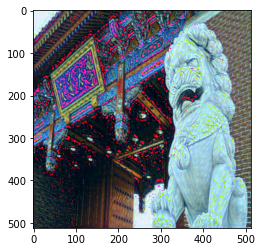

In [33]:
plt.imshow(new_pic)